# Testing Prospector Model & Likelihood

In [1]:
import os
import numpy as np
os.environ["SPS_HOME"] = '/global/homes/e/eramey16/fsps/'
h5_file = os.path.expandvars("10995462702105256_extra_samples.h5")

from docker import param_monocle as param
from docker import classify
import prospect.io.read_results as reader

import h5py
import pickle
import dynesty

In [2]:
res1, _, _ = reader.results_from(h5_file)

mag_unc_1 = np.array([0.005395851583585794, 0.0034580493543346622, 0.004425482546800575,
                 0.004152162899013791, 0.011291867461568727, 0.04210798998385776])*5
args_1 = {
    "mag_in": [20.717947, 19.274029, 18.668655, 18.314737, 17.77136, 18.470882],
    "mag_unc_in": mag_unc_1,
    "object_redshift": None,
}
run_params = param.run_params
obs_1, model_1, sps_1, noise_model_1 = param.load_all(args=args_1, **run_params)
spec_noise_1, phot_noise_1 = noise_model_1

Loaded observation
Loaded SPS libraries


In [3]:
mag_unc_2 = np.array([0.005395851583585794, 0.0034580493543346622, 0.004425482546800575,
                 0.004152162899013791, 0.011291867461568727, 0.04210798998385776])
args_2 = {
    "mag_in": [20.717947, 19.274029, 18.668655, 18.314737, 17.77136, 18.470882],
    "mag_unc_in": mag_unc_2,
    "object_redshift": None,
}

obs_2, model_2, sps_2, noise_model_2 = param.load_all(args=args_2, **run_params)
spec_noise_2, phot_noise_2 = noise_model_2

Loaded observation
Loaded SPS libraries


In [4]:
def loglikelihood1(theta_vec):
    return param.lnprobfn(theta_vec, model=model_1, obs=obs_1, def_sps=sps_1,
                          def_noise_model=noise_model_1)
def loglikelihood2(theta_vec):
    return param.lnprobfn(theta_vec, model=model_2, obs=obs_2, def_sps=sps_2, 
                          def_noise_model=noise_model_2)

In [5]:
# loglikelihood1(res1['chain'][0,:]), loglikelihood2(res1['chain'][0,:])

In [6]:
with open('10995462702105256_extra_samples.pkl', 'rb') as file:
    dres = pickle.load(file)

In [ ]:
N = dres['samples'].shape[0]
logl2 = [loglikelihood2(dres['samples'][i]) for i in range(N)]

In [ ]:
dres_rwt = dynesty.utils.reweight_run(dres, logp_new=logl2)

In [ ]:
len(dres['samples'][0])

In [ ]:
# res1['chain']

In [ ]:
# dres['logwt']

In [ ]:
# dres_rwt['logwt']

In [ ]:
import prospect.io.write_results as writer
writer.write_hdf5("10995462702105256_extra_samples_rwt.h5", {}, model_2, obs_2, dres_rwt, None, sps=sps_2, tsample=None, toptimize=0.0)

# Plotting reweighted vs. regular

In [1]:
import os
import numpy as np
os.environ["SPS_HOME"] = '/global/homes/e/eramey16/fsps/'
h5_regular = "10995462702105256_extra_samples.h5"
h5_rwt = "10995462702105256_extra_samples_rwt.h5"

from docker import param_monocle as param
from docker import classify
import prospect.io.read_results as reader
from prospect.io.read_results import traceplot
from prospect.plotting.utils import sample_posterior
from astropy.cosmology import WMAP9

import h5py
import pickle
import dynesty
import matplotlib.pyplot as plt
import corner as triangle

In [2]:
run_params = param.run_params

In [3]:
res_reg, obs_reg, _ = reader.results_from(h5_regular)
model_reg = param.load_model(obs=obs_reg, **run_params)

In [4]:
res_rwt, obs_rwt, _ = reader.results_from(h5_rwt)
model_rwt = param.load_model(obs=obs_rwt, **run_params)

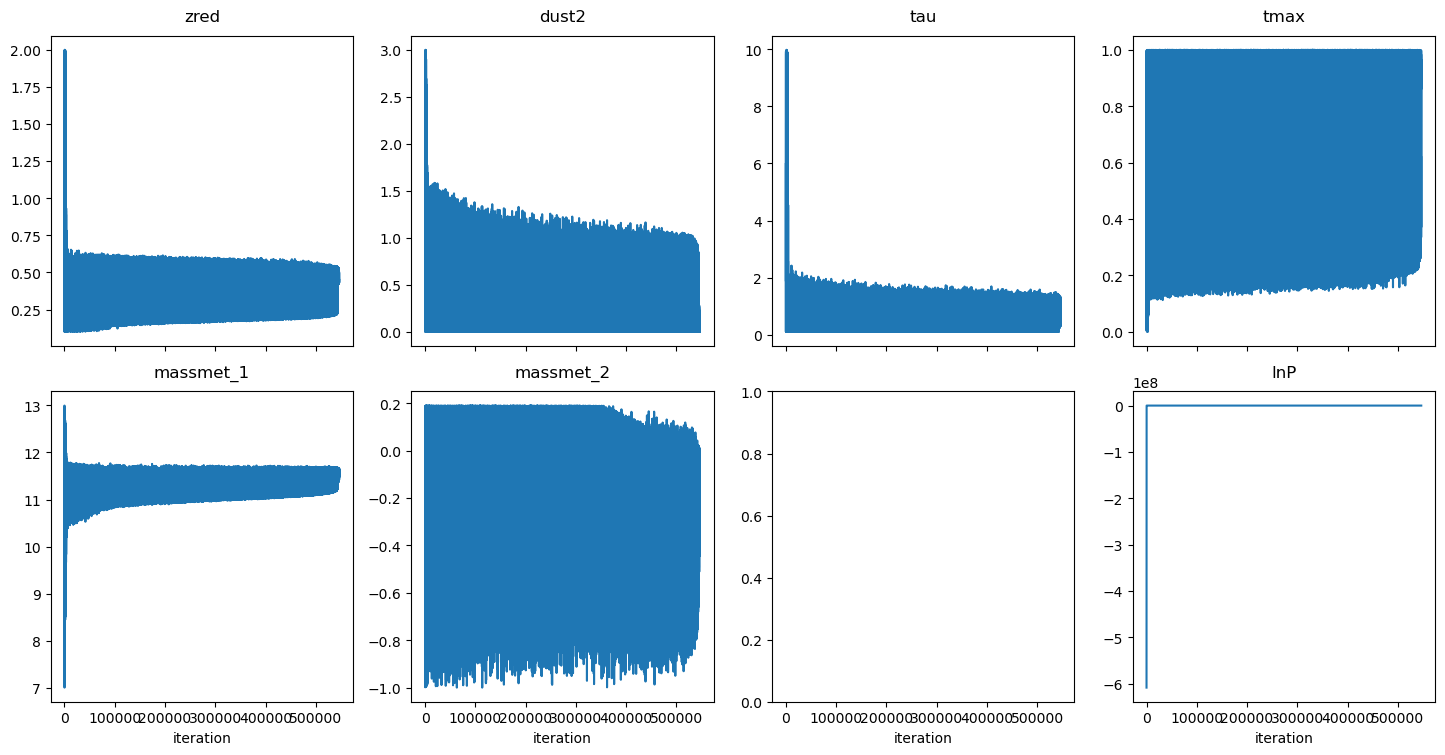

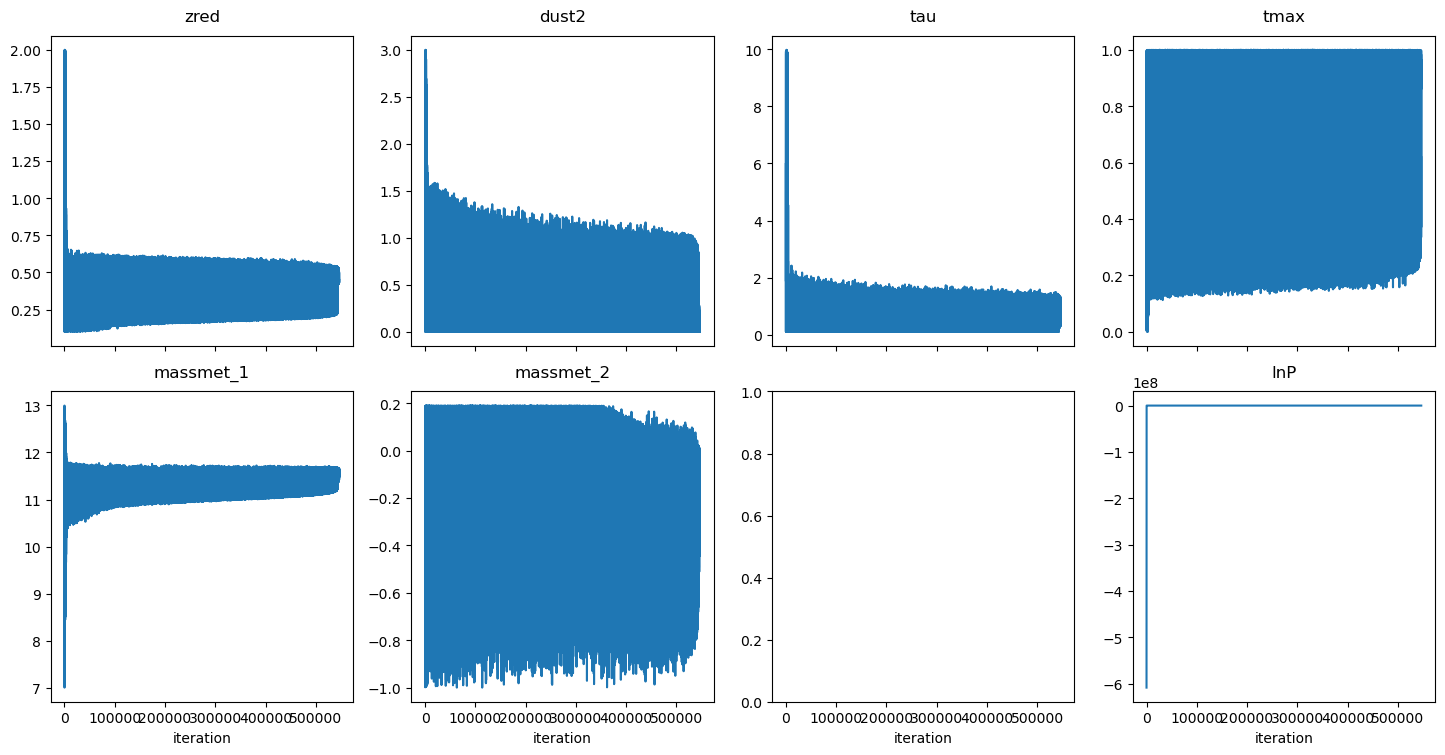

In [5]:
traceplot(res_reg)

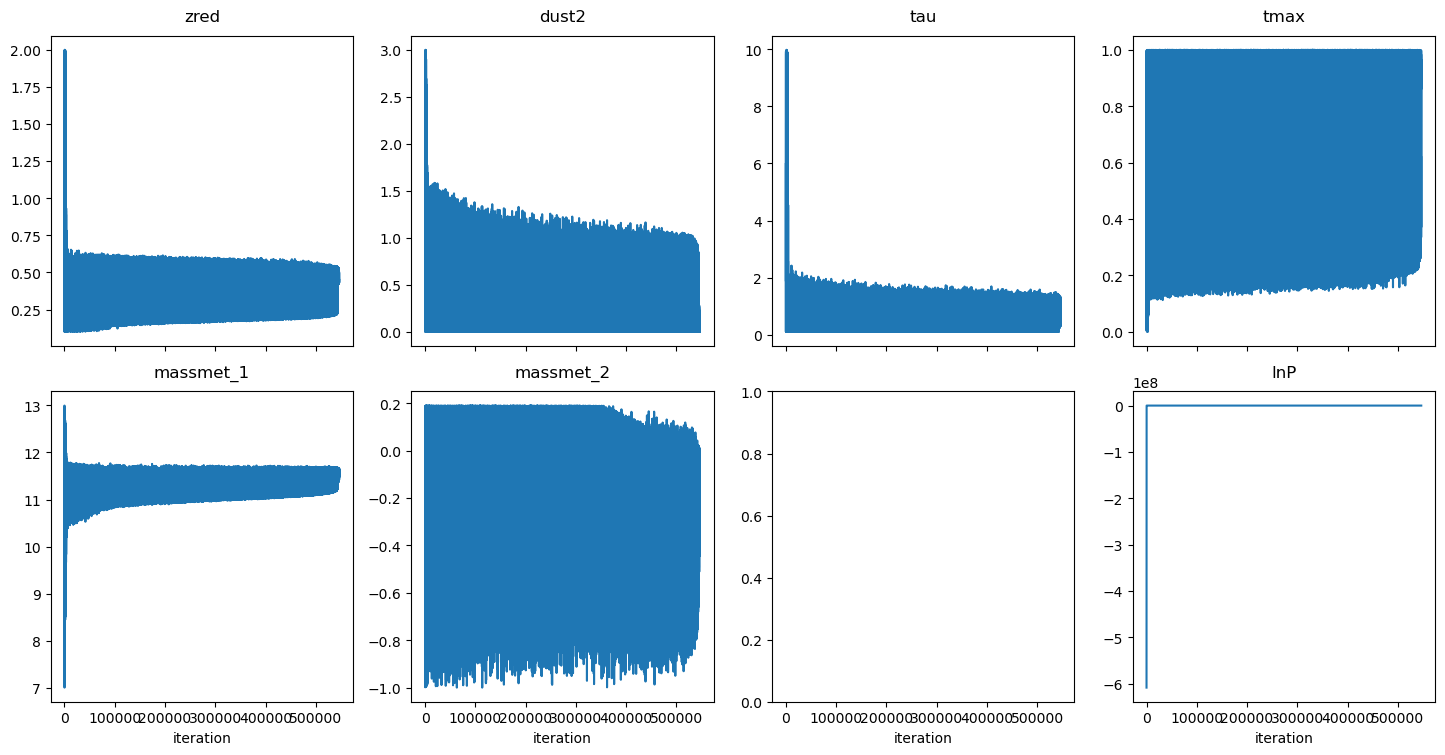

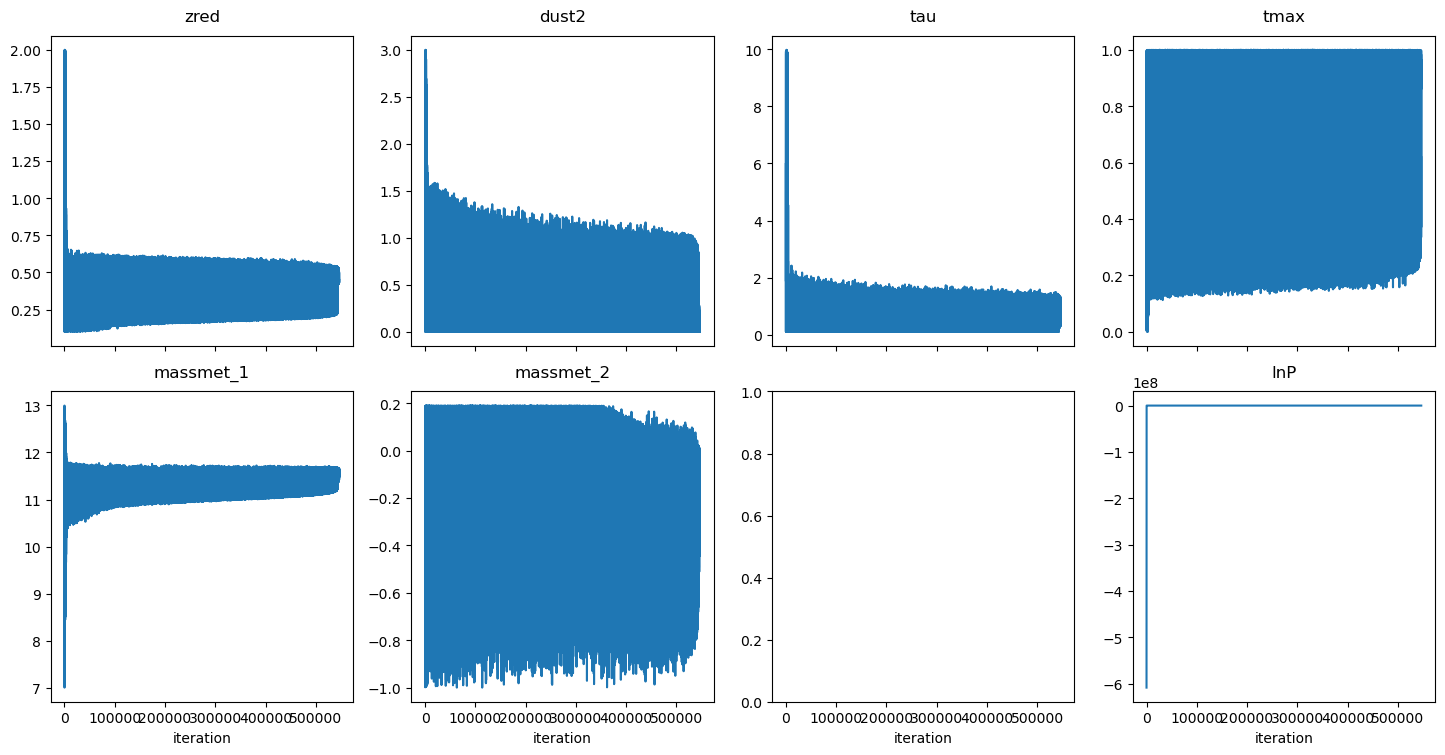

In [6]:
traceplot(res_rwt)

In [7]:
def age(tage, tau):
    """
    Function to convert from tage and tau to mass-weighted age
    Note that mass-weighted age = tage - age(tage, tau)
    This only works for a delayed-tau SFH
    """
    age = 2*tau - tage**2/(tau*np.exp(tage/tau)-tau-tage)
    return age

def SFR(tage, tau, mass):
    """
    To determine SFR from delayed-tau SFH
    Takes in lists of tage, tau and mass
    Outputs SFR in M_sol/yr
    """
    psi_arr = []
    
    for i in np.arange(0, len(tage), 1):
        # for delay tau this function gives the (unnormalized) SFR 
        # for any t, tau combo in M_sun/Gyr
        tau_i = tau[i]
        sfr = lambda t,tau_i: (t) * np.exp(-t/tau_i)
        # now we numerically integrate this SFH from 0 to tage to get the mass formed
        times = np.linspace(0, tage[i], 1000)
        A = np.trapz(sfr(times, tau[i]), times)
        # and now we renormalize the formed mass to the actual mass value 
        # to get the the SFR in M_sun per Gyr 
        psi = mass[i] * sfr(tage[i], tau[i]) / A
        # if we want SFR in Msun/year
        psi /= 1e9
        psi_arr.append(psi)
    return np.array(psi_arr)

def sm(t_m, logMF):
    logtm = np.log10(t_m * 1e9)
    MF = 10**logMF
    logsm = 1.06 - 0.24 * logtm + 0.01*(logtm**2)
    
    sm = 10**logsm
    mass = sm * MF
    return np.log10(mass)


def specific_SFR(mass, z, sfr):
    # First solve for sSFR using full post. dist of mass and SFR
    # Take the mode perhaps? for redshift free
    sSFR = np.log10(np.array(sfr)/(10**np.array(mass)))
    # Find lookback time    
    type_SF = []
    # If z was fixed in the fit, t_lookback is a single value
    if type(z) == float:
        t_lookback = tage_from_tuniv(zred=z, tage_tuniv=1.0)*1e9

        for s in sSFR:
            sf_cond = np.log10(1/3/(t_lookback))
            q_cond = np.log10(1/20/(t_lookback))
            
            if s >= sf_cond:
                type_SF.append('SF')
            elif (s < sf_cond) & (s > q_cond):
                type_SF.append('T')
            else: 
                type_SF.append('Q')  
                
    else:
        for i in np.arange(0, len(z), 1):
            t_lookback = tage_from_tuniv(zred=z[i], tage_tuniv=1.0)*1e9
            
            sf_cond = np.log10(1/3/(t_lookback))
            q_cond = np.log10(1/20/(t_lookback))
            
            if sSFR[i] >= sf_cond:
                type_SF.append('SF')
            elif (sSFR[i] < sf_cond) & (sSFR[i] > q_cond):
                type_SF.append('T')
            else: 
                type_SF.append('Q')   
    
    SF_mode = scipy.stats.mode(type_SF)[0][0]
    
    return SF_mode, sSFR

def tmax_to_tage(tmax=None,redshift=None,**kwargs):
    return WMAP9.age(redshift).value*(tmax) # in Gyr
    
def theta_corner_spec(results, param_latex, model, **kwargs):
    # Get parameter names 
    parnames = np.array(results['theta_labels'], dtype='U20')

     # Get the arrays we need (trace, wghts)
    samples = results['chain']
    xx = samples.copy()
    wghts = results.get('weights', None)

    # Resample posterior using weights to 100k uniformly-sampled weights    
    theta_samp = sample_posterior(xx, weights=wghts, nsample=100000)

    # Change from optical depth to dust: note must have dust2 as free parameter for this to work
    if 'dust1' in model.params:
        # Calculate total dust from dust1 and dust2 contributions: AV = (dust1 + dust2)*1.086 
        # dust1 = 0.5 * dust2
        dust2 = 1.5*1.086*theta_samp[:, parnames.tolist().index('dust2')]
    else:    
        dust2 = theta_samp[:, parnames.tolist().index('dust2')]*1.086

    # Define some variables
    t_age_par = theta_samp[:, parnames.tolist().index('tage')]
    t_age = t_age_par.copy()
    tau = theta_samp[:, parnames.tolist().index('tau')]
    mass = 10**theta_samp[:, parnames.tolist().index('massmet_1')]
    mass_log = theta_samp[:, parnames.tolist().index('massmet_1')]


    logzsol = theta_samp[:, parnames.tolist().index('massmet_2')]
    gaslogz = theta_samp[:, parnames.tolist().index('gas_logz')]

    # Convert from tage to mass-weighted age
    t_m =  t_age - age(t_age,tau)
    # Calculate SFR
    SFR_calc = SFR(t_age, tau, mass)

    stell_mass = sm(t_m, mass_log)

    # We want to plot dust2, t_m, tau, SFR, M, Z , Z_gas
    
    if 'zred' in parnames:
        zred = theta_samp[:, parnames.tolist().index('zred')]
        new_theta = []
        for i in np.arange(0, len(mass_log), 1):
            new_idx = [zred[i], dust2[i], t_m[i], tau[i], SFR_calc[i], stell_mass[i], logzsol[i], gaslogz[i]]
            new_theta.append(new_idx)
            
            
    else:
        new_theta = []
        for i in np.arange(0, len(mass_log), 1):
            new_idx = [dust2[i], t_m[i], tau[i], SFR_calc[i], stell_mass[i], logzsol[i], gaslogz[i]]
            new_theta.append(new_idx)
            
            
        for i in np.arange(0, len(res['model_params']),1):
            if res['model_params'][i]['name'] == 'zred':
                if res['model_params'][i]['isfree'] == False:
                    zred = res['model_params'][i]['init'] 
                    
    SF_mode, sSFR = specific_SFR(stell_mass, zred, SFR_calc)
    print(SF_mode, np.quantile(sSFR, [0.16, 0.5, 0.84, 0.99]))


    new_theta = np.array(new_theta)

    # plot figure
    figure = triangle.corner(new_theta, quantiles=[0.16, 0.50, 0.84], show_titles=True, labels = param_latex,
                             color = 'darkcyan', hist_kwargs = {"alpha": 1, "linewidth":3}, 
                             title_fmt = ' .2f', contour_kwargs={"linewidths":3}, **kwargs)
    return figure


def theta_corner_IR(results, param_latex, model, **kwargs):
    # Get parameter names 
    parnames = np.array(results['theta_labels'], dtype='U20')

     # Get the arrays we need (trace, wghts)
    samples = results['chain']
    xx = samples.copy()
    wghts = results.get('weights', None)

    # Resample posterior using weights to 100k uniformly-sampled weights    
    theta_samp = sample_posterior(xx, weights=wghts, nsample=100000)

    if 'dust1' in model.params:
        # Calculate total dust from dust1 and dust2 contributions: AV = (dust1 + dust2)*1.086 
        # dust1 = 0.5 * dust2
        dust2 = 1.5*1.086*theta_samp[:, parnames.tolist().index('dust2')]
    else:    
        dust2 = theta_samp[:, parnames.tolist().index('dust2')]*1.086


    # Define some variables
    t_age_par = theta_samp[:, parnames.tolist().index('tage')]
    t_age = t_age_par.copy()
    tau = theta_samp[:, parnames.tolist().index('tau')]
    mass = 10**theta_samp[:, parnames.tolist().index('massmet_1')]
    mass_log = theta_samp[:, parnames.tolist().index('massmet_1')]


    logzsol = theta_samp[:, parnames.tolist().index('massmet_2')]
    gaslogz = theta_samp[:, parnames.tolist().index('gas_logz')]

    fagn = theta_samp[:, parnames.tolist().index('fagn')]
    tau_agn = theta_samp[:, parnames.tolist().index('agn_tau')]
    #duste_umin = theta_samp[:, parnames.tolist().index('duste_umin')]
    #duste_qpah = theta_samp[:, parnames.tolist().index('duste_qpah')]
    #duste_gamma = theta_samp[:, parnames.tolist().index('duste_gamma')]

    # Convert from tage to mass-weighted age
    t_m =  t_age - age(t_age,tau)
    # Calculate SFR
    SFR_calc = SFR(t_age, tau, mass) 

    stell_mass = sm(t_m, mass_log)

    # We want to plot dust2, t_m, tau, SFR, M, Z , Z_gas

    new_theta = []


    if 'zred' in parnames:
        zred = theta_samp[:, parnames.tolist().index('zred')]
        new_theta = []
        for i in np.arange(0, len(mass_log), 1):
            new_idx = [zred[i], dust2[i], t_m[i], tau[i], SFR_calc[i], stell_mass[i], logzsol[i],
                       gaslogz[i], fagn[i], tau_agn[i]] #, duste_umin[i], duste_qpah[i], duste_gamma[i]]
            new_theta.append(new_idx)


    else:
        new_theta = []
        for i in np.arange(0, len(mass_log), 1):
            new_idx = [dust2[i], t_m[i], tau[i], SFR_calc[i], stell_mass[i], logzsol[i], gaslogz[i],
                       fagn[i], tau_agn[i]] #, duste_umin[i], duste_qpah[i], duste_gamma[i]]
            new_theta.append(new_idx)

   # AGN: 

    new_theta = np.array(new_theta)

    # plot figure
    figure = triangle.corner(new_theta, quantiles=[0.16, 0.50, 0.84], show_titles=True, labels = param_latex,
                             color = 'darkcyan', hist_kwargs = {"alpha": 1, "linewidth":3}, 
                             title_fmt = ' .2f', contour_kwargs={"linewidths":3}, **kwargs)


    return figure

def theta_corner_phot(results, param_latex, model, **kwargs):
    # Get parameter names 
    parnames = np.array(results['theta_labels'], dtype='U20')

     # Get the arrays we need (trace, wghts)
    samples = results['chain']
    xx = samples.copy()
    wghts = results.get('weights', None)

    # Resample posterior using weights to 100k uniformly-sampled weights    
    theta_samp = sample_posterior(xx, weights=wghts, nsample=100000)

    # Change from optical depth to dust: note must have dust2 as free parameter for this to work
    if 'dust1' in model.params:
        # Calculate total dust from dust1 and dust2 contributions: AV = (dust1 + dust2)*1.086 
        # dust1 = 0.5 * dust2
        dust2 = 1.5*1.086*theta_samp[:, parnames.tolist().index('dust2')]
    else:    
        dust2 = theta_samp[:, parnames.tolist().index('dust2')]*1.086

    
    mass = 10**theta_samp[:, parnames.tolist().index('massmet_1')]
    mass_log = theta_samp[:, parnames.tolist().index('massmet_1')]

    logzsol = theta_samp[:, parnames.tolist().index('massmet_2')]

    

    # We want to plot dust2, t_m, tau, SFR, M, Z , Z_gas and redshift if it exists

    if 'zred' in parnames:
        # Define some variables
        zred = theta_samp[:, parnames.tolist().index('zred')]

        tmax_par = theta_samp[:, parnames.tolist().index('tmax')]
        t_age = tmax_to_tage(tmax=tmax_par,redshift=zred)
        tau = theta_samp[:, parnames.tolist().index('tau')]
        
        # Convert from tage to mass-weighted age
        t_m =  t_age - age(t_age,tau)
        # Calculate SFR
        SFR_calc = SFR(t_age, tau, mass) 

        stell_mass = sm(t_m, mass_log)   
        
        new_theta = []
        for i in np.arange(0, len(mass_log), 1):
            new_idx = [zred[i], dust2[i], t_m[i], tau[i], SFR_calc[i], stell_mass[i], logzsol[i]]
            new_theta.append(new_idx)

    else:
        # Define some variables
        t_age_par = theta_samp[:, parnames.tolist().index('tage')]
        t_age = t_age_par.copy()
        tau = theta_samp[:, parnames.tolist().index('tau')]
        
        # Convert from tage to mass-weighted age
        t_m =  t_age - age(t_age,tau)
        # Calculate SFR
        SFR_calc = SFR(t_age, tau, mass) 

        stell_mass = sm(t_m, mass_log)
        
        new_theta = []
        for i in np.arange(0, len(mass_log), 1):
            new_idx = [dust2[i], t_m[i], tau[i], SFR_calc[i], stell_mass[i], logzsol[i]]
            new_theta.append(new_idx)
            
        print(np.median(stell_mass))

    new_theta = np.array(new_theta)

    # plot figure
    if 'color' not in kwargs:
        kwargs['color'] = 'darkcyan'
    figure = triangle.corner(new_theta, quantiles=[0.16, 0.50, 0.84], show_titles=True, labels = param_latex,
                             hist_kwargs = {"alpha": 1, "linewidth":3}, 
                             title_fmt = ' .2f', contour_kwargs={"linewidths":3}, **kwargs)
    
    return figure


def theta_corner_gen(results, param_latex, model, **kwargs):
    # Get parameter names 
    parnames = np.array(results['theta_labels'], dtype='U20')

     # Get the arrays we need (trace, wghts)
    samples = results['chain']
    xx = samples.copy()
    wghts = results.get('weights', None)

    # Resample posterior using weights to 100k uniformly-sampled weights    
    theta_samp = sample_posterior(xx, weights=wghts, nsample=100000)

    # Change from optical depth to dust: note must have dust2 as free parameter for this to work
    if 'dust1' in model.params:
        # Calculate total dust from dust1 and dust2 contributions: AV = (dust1 + dust2)*1.086 
        # dust1 = 0.5 * dust2
        dust2 = 1.5*1.086*theta_samp[:, parnames.tolist().index('dust2')]
    else:    
        dust2 = theta_samp[:, parnames.tolist().index('dust2')]*1.086

    # Define some variables
    tau = theta_samp[:, parnames.tolist().index('tau')]
    mass = 10**theta_samp[:, parnames.tolist().index('massmet_1')]
    mass_log = theta_samp[:, parnames.tolist().index('massmet_1')]

    logzsol = theta_samp[:, parnames.tolist().index('massmet_2')]
    
    duste_umin = theta_samp[:, parnames.tolist().index('duste_umin')]
    duste_qpah = theta_samp[:, parnames.tolist().index('duste_qpah')]
    duste_gamma = theta_samp[:, parnames.tolist().index('duste_gamma')]

    # We want to plot dust2, t_m, tau, SFR, M, Z , Z_gas and redshift if it exists

    if 'zred' in parnames:
        # Define some variables
        zred = theta_samp[:, parnames.tolist().index('zred')]

        tmax_par = theta_samp[:, parnames.tolist().index('tmax')]
        t_age = tmax_to_tage(tmax=tmax_par,redshift=zred)
        tau = theta_samp[:, parnames.tolist().index('tau')]
        
        # Convert from tage to mass-weighted age
        t_m =  t_age - age(t_age,tau)
        # Calculate SFR
        SFR_calc = SFR(t_age, tau, mass) 
        
        new_theta = []
        for i in np.arange(0, len(mass_log), 1):
            new_idx = [zred[i], dust2[i], t_m[i], tau[i], SFR_calc[i], stell_mass[i], logzsol[i], duste_umin[i],
                       duste_qpah[i], duste_gamma[i]]
            new_theta.append(new_idx)

    else:
        t_age_par = theta_samp[:, parnames.tolist().index('tage')]
        t_age = t_age_par.copy()
        # Convert from tage to mass-weighted age
        t_m =  t_age - age(t_age,tau)
        # Calculate SFR
        SFR_calc = SFR(t_age, tau, mass) 

        stell_mass = sm(t_m, mass_log)
    
        new_theta = []
        for i in np.arange(0, len(mass_log), 1):
            new_idx = [dust2[i], t_m[i], tau[i], SFR_calc[i], stell_mass[i], logzsol[i], duste_umin[i],
                       duste_qpah[i], duste_gamma[i]]
            new_theta.append(new_idx)

    new_theta = np.array(new_theta)

    # plot figure
    figure = triangle.corner(new_theta, quantiles=[0.16, 0.50, 0.84], show_titles=True, labels = param_latex,
                             color = 'darkcyan', hist_kwargs = {"alpha": 1, "linewidth":3}, 
                             title_fmt = ' .2f', contour_kwargs={"linewidths":3}, **kwargs)
    
    return figure

In [8]:
platex_phot2 = np.array([r'z', r'$A_V$', r'$t_{m}$ [Gyr]', r'$\tau$', r'SFR', 
                                        r'log(M/M$_{\odot}$)', r'log(Z/Z$_{\odot}$)'], dtype='U20')

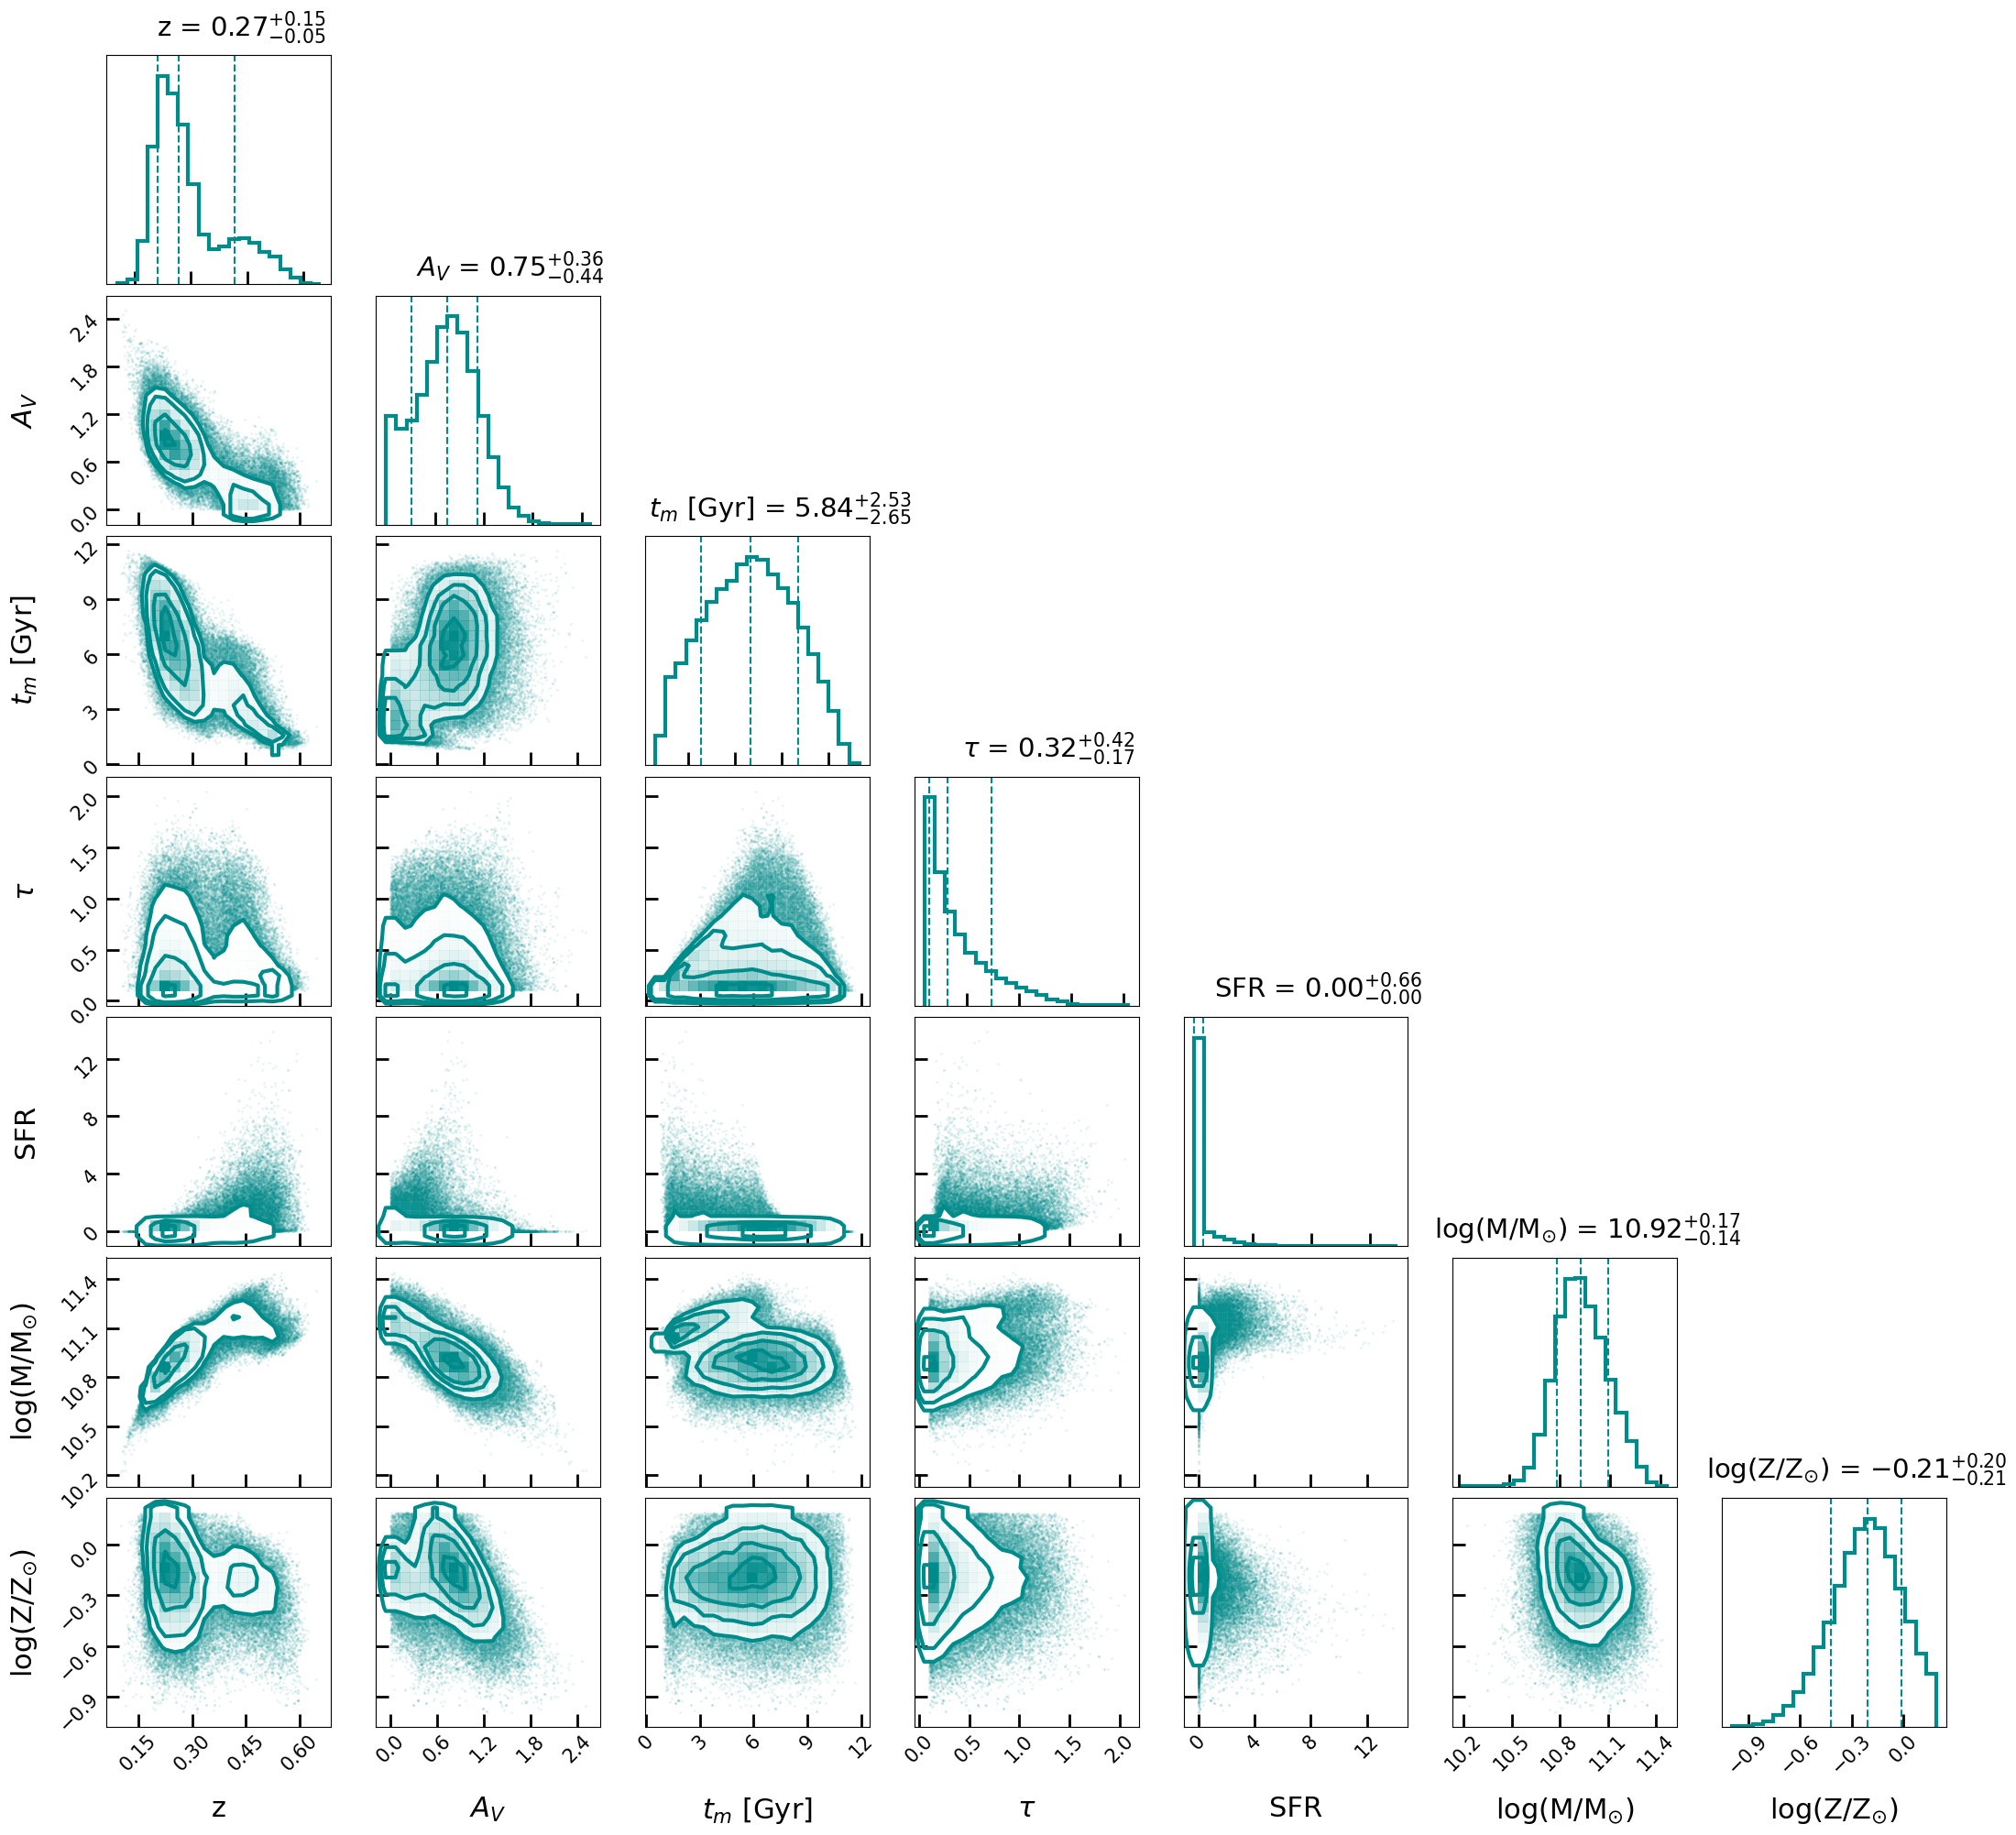

In [13]:
cornerfig = theta_corner_phot(res_reg, platex_phot2, model=model_reg, 
                              fig=plt.subplots(7,7,figsize=(22,20))[0], 
                              title_kwargs={"fontsize": 21, 'x': 0.6, 'y':1.05}, 
                              label_kwargs={"fontsize": 22}, label_fmt = ' .2f')
    
# cornerfig2 = theta_corner_phot(res_rwt, platex_phot2, model=model_rwt, 
#                               fig=cornerfig, color='red',
#                               title_kwargs={"fontsize": 21, 'x': 0.6, 'y':1.05}, 
#                               label_kwargs={"fontsize": 22}, label_fmt = ' .2f')
for ax in cornerfig.get_axes():
    ax.tick_params(axis='both', labelsize=15, length=10, width=2, direction='in')

plt.subplots_adjust(wspace=0.20, hspace=0.05)
plt.show()
# plt.savefig("10995462702105256_reg_plot.png", bbox_inches='tight')

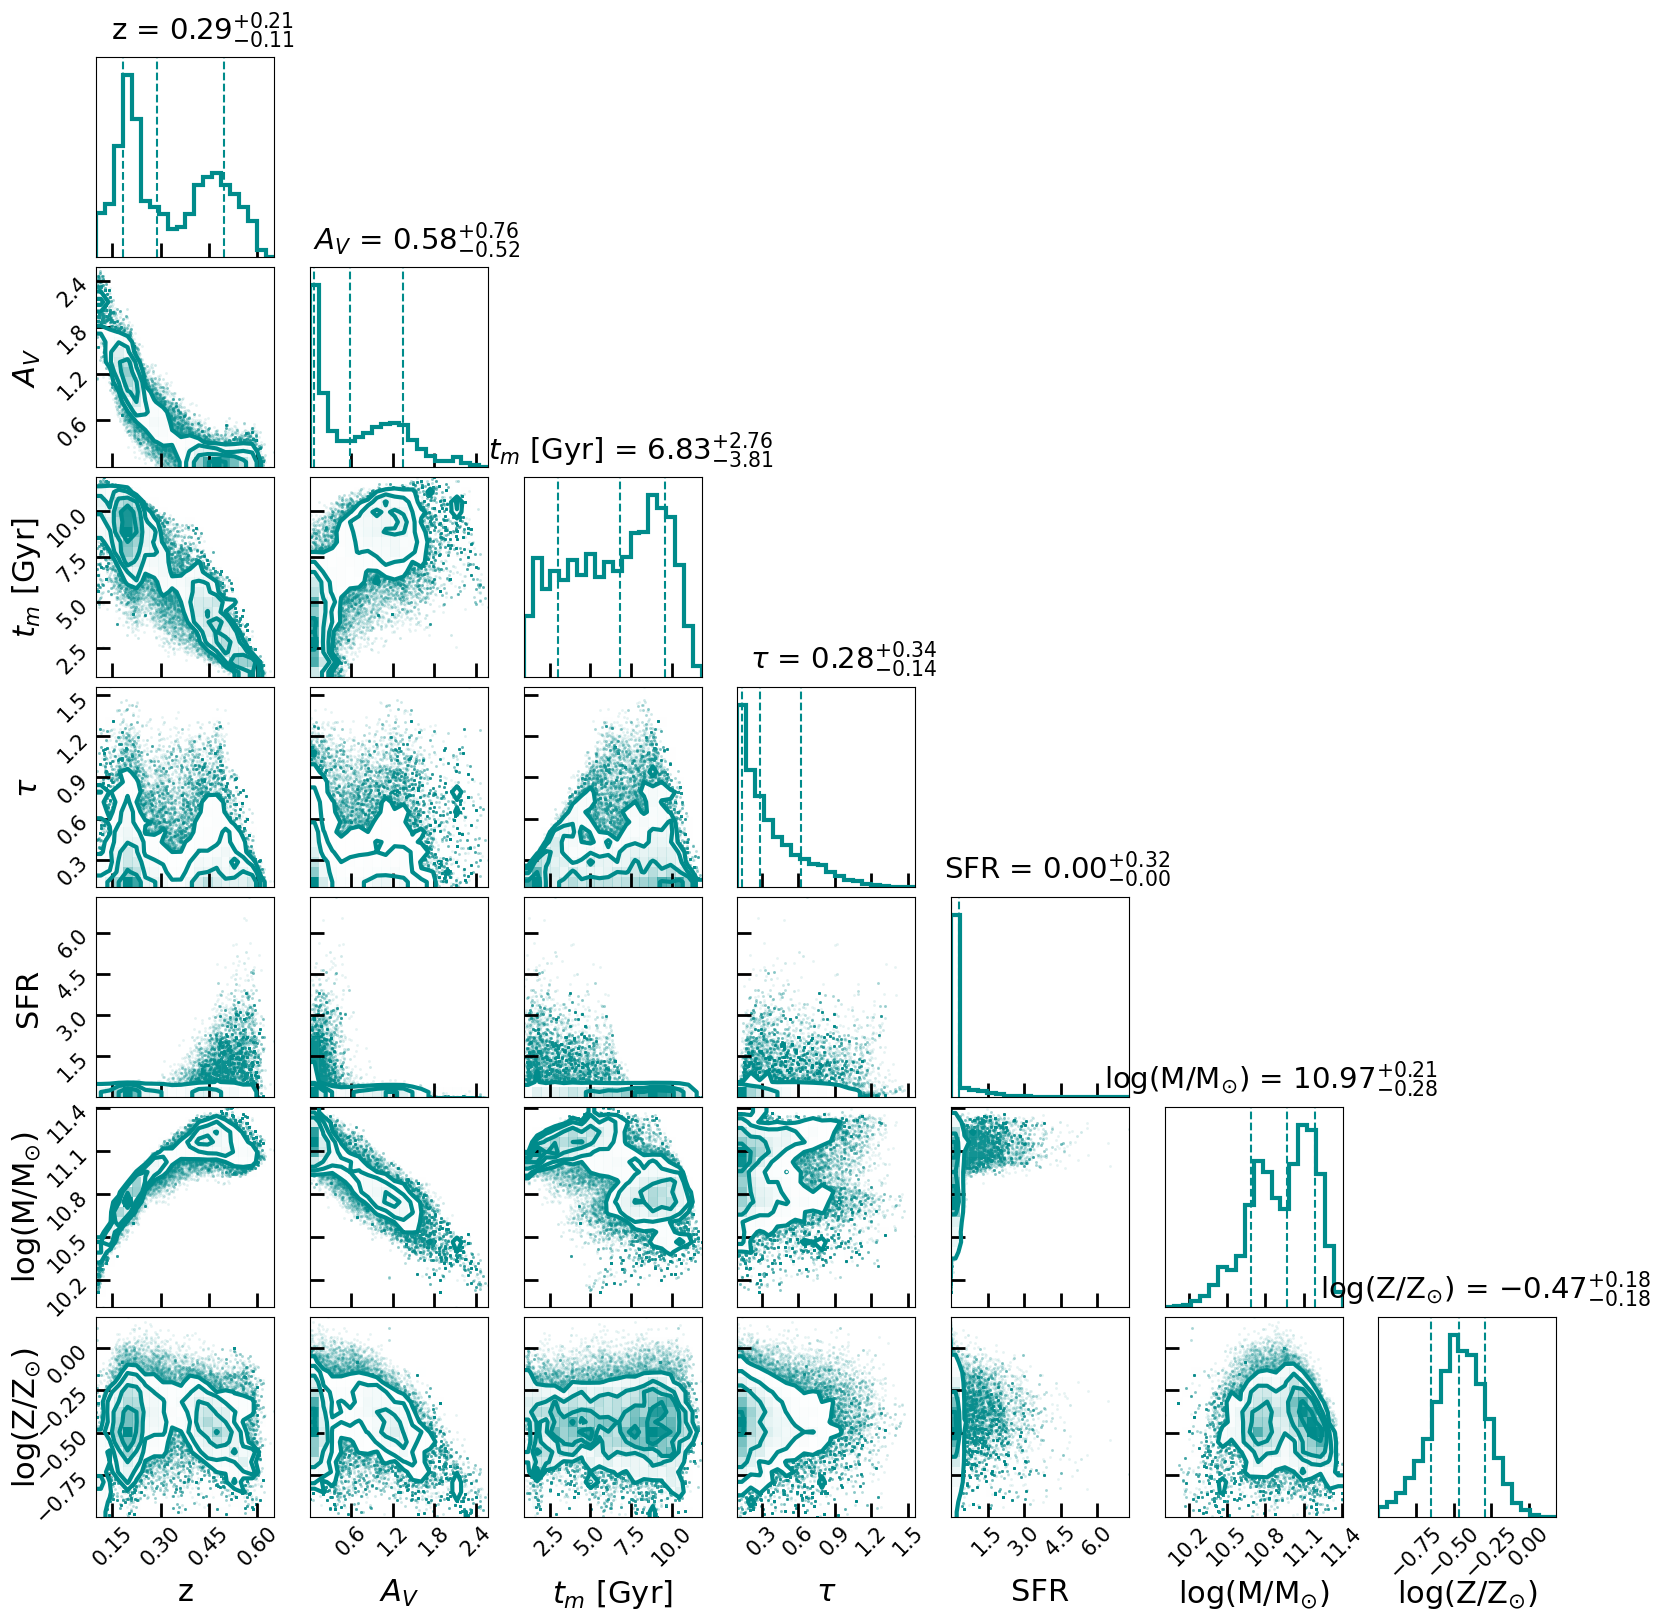

In [17]:
cornerfig = theta_corner_phot(res_rwt, platex_phot2, model=model_rwt,
                              title_kwargs={"fontsize": 21, 'x': 0.6, 'y':1.05}, 
                              label_kwargs={"fontsize": 22}, label_fmt = ' .2f')
for ax in cornerfig.get_axes():
    ax.tick_params(axis='both', labelsize=15, length=10, width=2, direction='in')

plt.subplots_adjust(wspace=0.20, hspace=0.05)
plt.show()
# plt.savefig("10995462702105256_rwt_plot.png", bbox_inches='tight')

# Tutorial on importance re-weighting

In [10]:
# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
from numpy import linalg

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt

# seed the random number generator
rstate = np.random.default_rng(510)
import dynesty

In [11]:
ndim = 3  # number of dimensions
C = np.identity(ndim)  # set covariance to identity matrix
C[C==0] = 0.95  # set off-diagonal terms (strongly correlated)
Cinv = linalg.inv(C)  # precision matrix
lnorm = -0.5 * (np.log(2 * np.pi) * ndim + np.log(linalg.det(C)))  # ln(normalization)

# 3-D correlated multivariate normal log-likelihood
def loglikelihood(x):
    """Multivariate normal log-likelihood."""
    return -0.5 * np.dot(x, np.dot(Cinv, x)) + lnorm

In [12]:
# prior transform
def prior_transform(u):
    """Transforms our unit cube samples `u` to a flat prior between -10. and 10. in each variable."""
    return 10. * (2. * u - 1.)

In [13]:
# initialize our nested sampler
dsampler = dynesty.DynamicNestedSampler(loglikelihood, prior_transform, ndim=3,
                                        bound='single', sample='unif', rstate=rstate)
dsampler.run_nested(maxiter=500, use_stop=False)
dres = dsampler.results

iter: 50001 | batch: 22 | bound: 2 | nc: 1 | ncall: 877799 | eff(%):  5.696 | loglstar:   -inf < -0.407 < -1.059 | logz: -8.965 +/-  0.044 | stop:    nan                                             

In [18]:
import pickle

In [24]:
path = os.path.expandvars("$SCRATCH/data/monocle/test/deleteme_dynesty.dat")
with open(path, 'wb') as file:
    pickle.dump(dres, file)

In [25]:
with open(path, 'rb') as file:
    results_pkl = pickle.load(file)

In [17]:
dres.summary()

Summary
niter: 50001
ncall: 877799
eff(%):  5.696
logz: -8.923 +/-  0.043


In [16]:
dres.keys()

['niter',
 'ncall',
 'eff',
 'samples',
 'samples_id',
 'samples_batch',
 'samples_it',
 'samples_u',
 'samples_n',
 'logwt',
 'logl',
 'logvol',
 'logz',
 'batch_nlive',
 'batch_bounds',
 'logzerr',
 'information',
 'bound',
 'bound_iter',
 'samples_bound',
 'scale']

# Older stuff:

In [1]:
import os
os.environ["SPS_HOME"] = '/global/homes/e/eramey16/fsps/'

import fsps
import dynesty
import sedpy
import h5py, astropy
import numpy as np
import pandas as pd
from docker import classify

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
ls_id = 9906619143751091 #IPTF16geu

In [3]:
from prospect import prospect_args
parser = prospect_args.get_parser()
parser.print_help()

usage: ipykernel_launcher.py [-h] [--verbose VERBOSE] [--debug]
                             [--outfile OUTFILE] [--output_pickle]
                             [--zcontinuous ZCONTINUOUS] [--optimize]
                             [--min_method MIN_METHOD] [--min_opts MIN_OPTS]
                             [--nmin NMIN] [--emcee] [--nwalkers NWALKERS]
                             [--niter NITER] [--nburn [NBURN ...]]
                             [--save_interval INTERVAL]
                             [--restart_from RESTART_FROM]
                             [--ensemble_dispersion INITIAL_DISP] [--dynesty]
                             [--nested_bound {single,multi,balls,cubes}]
                             [--nested_sample {unif,rwalk,slice}]
                             [--nested_walks NESTED_WALKS]
                             [--nlive_init NESTED_NLIVE_INIT]
                             [--nlive_batch NESTED_NLIVE_BATCH]
                             [--nested_dlogz_init NESTED_DLOGZ_

In [4]:
# Try it with a more standard fit
from sedpy.observate import load_filters
from prospect.utils.obsutils import fix_obs

bkdata, tbldata = classify.get_galaxy(ls_id=ls_id)
gal_data = tbldata.iloc[0]
gal_data

ls_id            9906619143751091
ra                     316.066216
dec                     -6.340221
type                          REX
dered_mag_g             20.250755
dered_mag_r              18.86748
dered_mag_z             17.944523
dered_mag_w1             17.25038
dered_mag_w2            17.611616
dered_flux_g             7.937765
dered_flux_r             28.37973
dered_flux_z             66.40348
dered_flux_w1           125.84846
dered_flux_w2            90.23046
snr_g                   128.86171
snr_r                   213.08531
snr_z                   480.05804
snr_w1                  143.01906
snr_w2                   59.99879
flux_ivar_g              430.3113
flux_ivar_r              78.43762
flux_ivar_z             62.868927
flux_ivar_w1             1.328257
flux_ivar_w2             0.449847
dchisq_1                236241.66
dchisq_2                263783.94
dchisq_3                266028.38
dchisq_4                264630.44
dchisq_5                      0.0
rchisq_g      

In [5]:
# Get galaxy data
bands = ['g', 'r', 'z', 'w1', 'w2']
sdss = ['sdss_{}0'.format(b) for b in ['g','r','z']]
wise = ['wise_w1', 'wise_w2']
filternames = sdss + wise

filters = load_filters(filternames)
maggies = np.array([10**(-.4*gal_data[f'dered_mag_{b}']) for b in bands])
magerr = [ 2.5 / (np.log(10) * gal_data['dered_flux_'+b] * 
                        np.sqrt(gal_data['flux_ivar_'+b])) for b in bands]
magerr = np.clip(magerr, 0.05, np.inf)

In [6]:
# Build obs
obs = dict(wavelength=None, spectrum=None, unc=None, redshift=gal_data['z_phot_median'],
           maggies=maggies, maggies_unc=magerr * maggies / 1.086, filters=filters)
obs = fix_obs(obs)

In [7]:
# Build model
from prospect.models.templates import TemplateLibrary
from prospect.models import PolySpecModel
model_params = TemplateLibrary["continuity_sfh"]
model_params.update(TemplateLibrary["nebular"])
model_params["zred"]["init"] = obs["redshift"]

model = PolySpecModel(model_params)
noise_model = (None, None)

print(model)

:::::::
<class 'prospect.models.sedmodel.PolySpecModel'>

Free Parameters: (name: prior) 
-----------
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  logmass: <class 'prospect.models.priors.TopHat'>(mini=7,maxi=12)
  logsfr_ratios: <class 'prospect.models.priors.StudentT'>(mean=[0. 0.],scale=[0.3 0.3],df=[2 2])

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.263183] 
  mass: [1000000.] <function logsfr_ratios_to_masses at 0x7f57687b7f70>
  sfh: [3] 
  imf_type: [2] 
  dust_type: [0] 
  agebins: [[ 0.  8.]
 [ 8.  9.]
 [ 9. 10.]] 
  add_neb_emission: [ True] 
  add_neb_continuum: [ True] 
  nebemlineinspec: [ True] 
  gas_logz: [0.] <function stellar_logzsol at 0x7f5768d96310>
  gas_logu: [-2.] 


In [8]:
from prospect.sources import CSPSpecBasis
sps = CSPSpecBasis(zcontinuous=1)
print(sps.ssp.libraries)

(b'mist', b'miles', b'DL07')


In [ ]:
from prospect.fitting import lnprobfn, fit_model
fitting_kwargs = dict(nlive_init=400, nested_method="rwalk", nested_target_n_effective=1000, nested_dlogz_init=0.05)
output = fit_model(obs, model, sps, optimize=True, dynesty=True, lnprobfn=lnprobfn, noise=noise_model, **fitting_kwargs)
result, duration = output["sampling"]

In [ ]:
from prospect.io import write_results as writer
hfile = "./quickstart_dynesty_mcmc.h5"
writer.write_hdf5(hfile, {}, model, obs,
                 output["sampling"][0], None,
                 sps=sps,
                 tsample=output["sampling"][1],
                 toptimize=0.0)